# QAOA with Amazon Braket Hybrid Jobs and PennyLane

In this tutorial, we use PennyLane within Amazon Braket Hybrid Jobs to run the Quantum Approximate Optimization Algorithm (QAOA) on a Max-Cut problem.

## Learning outcomes
* Use pre-built PennyLane containers in Braket Jobs
* Set QAOA hyperparameters 
* Choose PennyLane backend (TensorFlow, PyTorch, Base)
* Use checkpoints for Braket Jobs

## QAOA background 

QAOA is a variational algorithm that uses parameterized quantum circuits to evaluate a classical cost function given by a binary optimization problem; the circuit parameters are iteratively adjusted to minimize the cost function. The QAOA algorithm itself has different settings, such as circuit depth ($p$). In analogy to machine learning, these input settings are commonly referred to as _hyperparameters_. In the following, we show how to setup the problem, prepare input data and run QAOA using Braket Jobs.

For more information about QAOA and PennyLane, see [this example notebook](../../../../quantum_frameworks_and_plugins/pennylane/2_Graph_optimization_with_QAOA/2_Graph_optimization_with_QAOA.ipynb) or [this PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html).

## Problem setup

A Max Cut problem is the problem to find a cut in a graph that maximizes the number of edges between the two parts after the cut. It has applications in theoretical physics and in combinatorial optimizations. To get started, we first create and visualize a random graph for the Max-Cut problem with <code>networkx</code> package. Feel free to adjust the number of nodes, <code>n</code>, and number of edges, <code>m</code> as part of your experiments.

In [1]:
import time

import networkx as nx
from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.image_uris import Framework, retrieve_image
import matplotlib.pyplot as plt

%matplotlib inline

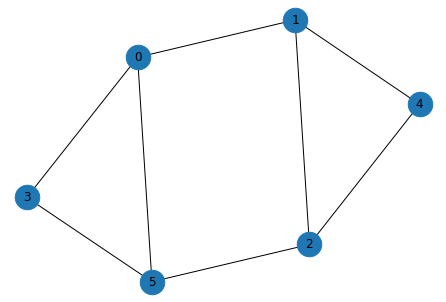

In [2]:
# We generate a random graph with num_nodes nodes and num_edges edges to run Max Cut on.
# num_nodes is the number of nodes in your graph, each represented by one qubit. 
# Caution: Circuit runtimes will scale exponentially with num_nodes
num_nodes = 6
num_edges = 8
seed = 1967

graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

## Prepare input data
We will prepare the optimization problem we want to solve, represented by the so-called Ising matrix, as the input data for the Braket Job. This best practice helps us decouple our problem definition from our algorithm code. If we want to solve another instance of this problem type, all we need to do is to point a new job to the new input data. The input data can be specified by either a path to a local file, or an Amazon S3 path that points to the data. For this example, we will create a file in the local directory encoding the problem graph.

In [3]:
input_file_path = "input-data.adjlist"
nx.write_adjlist(graph, input_file_path)

## Specify hyperparameters and configurations

"The hyperparameters can be passed in when you create your job, through the keyword argument <code>hyperparameters</code>. It usually includes all the algorithm settings you might want to adjust between runs to tailor your algorithm to the problem. This includes, for instance, the optimizer to use and its learning rate, the number of iterations, or the number of shots per device execution. 

In [4]:
# Pick 'autograd', 'tf', or 'torch'. Autograd is base PennyLane
def define_hyperparameters(interface):
    hyperparameters = {
        # Number of tasks per iteration = 2 * (num_nodes + num_edges) * p + 1
        "p": 2,
        "seed": seed,
        # Maximum number of simultaneous tasks allowed
        "max_parallel": 10,
        # Number of total optimization iterations, including those from previous checkpoint (if any)
        "num_iterations": 5,
        # Step size / learning rate for gradient descent
        "stepsize": 0.1,
        # Shots for each circuit execution
        "shots": 1000,
        "interface": interface,
    }
    return hyperparameters

Braket Jobs comes with three pre-configured container environments: TensorFlow, PyTorch and Base. 

In [5]:
from braket.aws import AwsSession

region = AwsSession().region

# Choose the container based on which one we need.
def select_container(interface):
    if interface == "autograd":
        image_uri = retrieve_image(Framework.BASE, region)
    elif interface == "tf":
        image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
    elif interface == "torch":
        image_uri = retrieve_image(Framework.PL_PYTORCH, region)
    return image_uri

## Algorithm script

The algorithm script we are going to use for solving the Max-Cut problem with QAOA can be found [here](qaoa/qaoa_algorithm_script.py).

## Submitting a Braket Job: Base Container

We have now finished preparing the input data, algorithm script, hyperparameters and other configurations. It's time to submit our Braket Job!

We specify the following arguments to create our job: 

- <code>device</code>: The arn of the Braket simulator or QPU we want to use. It will be stored as an environment variable for the algorithm script.
- <code>source_module</code>: The path to a file or a python module that contains your algorithm script. It will be uploaded to the container for Braket Job execution.
- <code>job_name</code>: A unique string to identify the job. It appears in the Braket Job console and in the job arn.
- <code>image_uri</code>: The path to a Docker container image.
- <code>entry point</code>: The path relative to the source_module. It points to the piece of code to be executed when the Braket Job starts.
- <code>copy_checkpoints_from_job</code>: A string that specifies the job arn whose checkpoint you want to use in the current job. If `None` (default value), no checkpoints will be copied to the current job.
- <code>hyperparameters</code>: The Python dictionary containing the hyperparameter names and values.
- <code>input_data</code>: A dictionary that maps channel names to either a file location in the local environment or a path to S3. We can also specify only a file location, in which case the channel name is treated as "input".
- <code>wait_until_complete</code>: If True, the function call will wait until the Braket Job is completed, and will additionally print logs to the local console. Otherwise, it will run asynchronously. Defaults to False.

In [6]:
# Using autograd interface with Base container
interface = "autograd"
hyperparameters = define_hyperparameters(interface)

# Specify device that the job will primarily be targeting
device = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

# setting up the image_uri 
image_uri = select_container(interface) 

In [7]:
job = AwsQuantumJob.create(
    device=device,
    source_module="qaoa",
    # Any unique name works. Note 50-character limit in job name
    # (comment out to use default naming)
    job_name="qaoa-job-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    # Relative to the source_module
    entry_point="qaoa.qaoa_algorithm_script",
    copy_checkpoints_from_job=None,
    # general parameters
    hyperparameters=hyperparameters,
    input_data={"input-graph": input_file_path},
    wait_until_complete=False,
)

## View results

After the job is completed, we can view the result and the metric we defined in the algorithm script.

In [8]:
%%time
# This cell should take 7-8  minutes
print(job.result())

{'params': [[-0.2213488042362593, -0.34576879319477966], [-0.07285138802088253, -0.17771989905871677]], 'cost': -2.612}
CPU times: user 254 ms, sys: 14.4 ms, total: 268 ms
Wall time: 6min


In [9]:
# May need to wait a bit before metrics show up
# If metrics aren't there, run a bit later
time.sleep(10)
print(job.metrics())

{'timestamp': [1652488190.9026933, 1652488142.3026094], 'Cost': [-4.045, -4.038], 'iteration_number': [2.0, 0.0]}


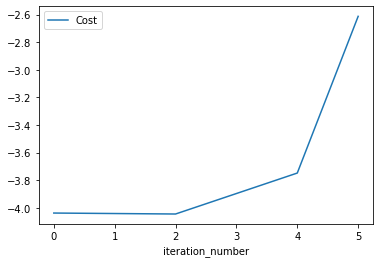

In [10]:
# A demonstration of plotting the metrics
import pandas as pd
from matplotlib.ticker import MaxNLocator

metrics_data = job.metrics()

if metrics_data: 
    df = pd.DataFrame(job.metrics())

    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    figure = df.plot(x="iteration_number", y="Cost", ax=ax)
else:
    print("Wait for metrics to populate and re-run the cell.")

In [11]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 286000, 'tasks': {'COMPLETED': 286}, 'execution_duration': 7.078, 'billed_execution_duration': 858.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 1.0725 USD


## Submitting a job: Tensorflow Container

In [12]:
# Using tensorflow interface with Tensorflow container
interface = "tf"
hyperparameters = define_hyperparameters(interface)

# Specify device that the job will primarily be targeting
device = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

# setting up the image_uri 
image_uri = select_container(interface) 

In [13]:
job = AwsQuantumJob.create(
    device=device,
    source_module="qaoa",
    # Any unique name works. Note 50-character limit in job name
    # (comment out to use default naming)
    job_name="qaoa-job-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    # Relative to the source_module
    entry_point="qaoa.qaoa_algorithm_script",
    copy_checkpoints_from_job=None,
    # general parameters
    hyperparameters=hyperparameters,
    input_data={"input-graph": input_file_path},
    wait_until_complete=False,
)

## View results

After the job is completed, we can view the result and the metric we defined in the algorithm script.

In [14]:
%%time
# This cell should take 8-9  minutes
print(job.result())

{'params': [[0.09565119708100346, -0.0701687943257777], [-0.2417513917193508, -0.18191990185268442]], 'cost': -4.142}
CPU times: user 405 ms, sys: 26.7 ms, total: 432 ms
Wall time: 9min 46s


In [15]:
# May need to wait a bit before metrics show up
# If metrics aren't there, run a bit later
time.sleep(10)
print(job.metrics())

{'timestamp': [1652488812.506036, 1652488788.0409968, 1652488761.6457057], 'Cost': [-3.955, -4.015, -4.054], 'iteration_number': [2.0, 1.0, 0.0]}


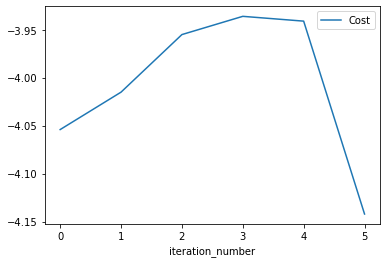

In [16]:
# A demonstration of plotting the metrics
import pandas as pd
from matplotlib.ticker import MaxNLocator

metrics_data = job.metrics()

if metrics_data: 
    df = pd.DataFrame(job.metrics())

    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    figure = df.plot(x="iteration_number", y="Cost", ax=ax)
else:
    print("Wait for metrics to populate and re-run the cell.")

In [25]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 286000, 'tasks': {'COMPLETED': 286}, 'execution_duration': 9.721, 'billed_execution_duration': 858.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 1.0725 USD


## Checkpoints

It is best practice to regularly save interim progress of your job as checkpoints. If your job terminates unexpectedly, for instance, if a QPU becomes unavailable, you can create a new job and load its training progress from a *checkpoint*. To save checkpoints, the algorithm script should contain code like the following:

In [18]:
%%script echo "Code in the algorithm script for saving a checkpoint"

for iteration in range(start_iteration, num_iterations):
    # Training code omitted ...
    # ...
    save_job_checkpoint(
        checkpoint_data={
            "iteration": iteration + 1,
            "params": np_params.tolist(),
            "cost_before": cost_before,
        },
        checkpoint_file_suffix="checkpoint-1",
    )

Code in the algorithm script for saving a checkpoint


This code creates and overwrites a checkpoint file `<jobname>-checkpoint-1.json` in your Job artifacts under a subfolder checkpoints. To load from a checkpoint at the start of a new job, the algorithm script should contain code like this:

In [19]:
%%script echo "Code in the algorithm script for loading a checkpoint"

if "copy_checkpoints_from_job" in hyperparams:
    copy_checkpoints_from_job = hyperparams["copy_checkpoints_from_job"].split("/", 2)[-1]

if copy_checkpoints_from_job:
    checkpoint_1 = load_job_checkpoint(
        copy_checkpoints_from_job,
        checkpoint_file_suffix="checkpoint-1",
    )
    start_iteration = checkpoint_1["iteration"]
    params = interface.initialize_params(np.array(checkpoint_1["params"]))
    print("Checkpoint loaded")

Code in the algorithm script for loading a checkpoint


This starts off the algorithm from the iteration and the parameters specified in the checkpoint file.

Let us see loading a checkpoint in action. We create a new job using the checkpoint from our existing job, this time training for another 2 iterations:

In [20]:
new_hyperparameters = dict(hyperparameters)
# Increase number of iterations by 2
new_hyperparameters["num_iterations"] = hyperparameters["num_iterations"] + 2
# Also add previous job arn in new hyperparameters
new_hyperparameters["copy_checkpoints_from_job"] = job.arn

start_time = time.time()

continued_job = AwsQuantumJob.create(
    device=device,
    source_module="qaoa",
    job_name="qaoa-job-continued-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    entry_point="qaoa.qaoa_algorithm_script",
    # We specify the previous job arn to copy checkpoints from
    copy_checkpoints_from_job=job.arn,
    hyperparameters=new_hyperparameters,
    input_data={"input-graph": input_file_path},
    wait_until_complete=False,
)

end_time = time.time()

In [21]:
%time 
# This cell should take 8-9 min
continued_job.result()

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.4 µs


{'params': [[0.5304512035600284, 0.20428120976384603],
  [-0.31945139287717106, -0.22541990250088492]],
 'cost': -4.9639999999999995}

In [22]:
# May need to wait a bit before metrics show up
# If metrics aren't there, run a bit later
time.sleep(10)
print(continued_job.metrics())

{'timestamp': [1652489391.446638, 1652489388.6802447, 1652489363.5430026], 'Cost': [-4.9639999999999995, -5.303, -4.203], 'iteration_number': [7.0, 6.0, 5.0]}


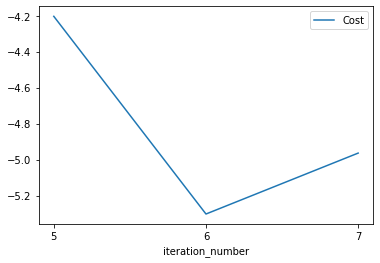

In [23]:
metrics_data = continued_job.metrics()

if metrics_data: 
    df = pd.DataFrame(continued_job.metrics())

    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    figure = df.plot(x="iteration_number", y="Cost", ax=ax)
else: 
    print("Wait for metrics to populate and re-run the cell.")

In [24]:
print("Task Summary")
print(continued_job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {continued_job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 115000, 'tasks': {'COMPLETED': 115}, 'execution_duration': 4.814, 'billed_execution_duration': 345.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 0.43125 USD


## Summary

In this tutorial, we set up a Max-Cut problem with a random graph using PennyLane. We saved the graph to a local file and provided it as input data to our Braket Job, and used the pre-built PennyLane container image to run it. Variables that are required for the training process and the optimizer are passed as hyperparameters. The result is retrieved after the QAOA algorithm is completed. Lastly, we demonstrated how to use checkpoints to save and load training progress of a job.